# 8 Queens Problem using Genetic Algorithms
# 08/28/2023

David Omar Paredes Paredes, 
Abraham Maximiliano Ávalos Corrales

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

In [2]:
class EvolutionaryAlgorithmQueens:
    def __init__(self,popsize=50,pcrossover=0.7,pmutation=0.1,maxIter=100,verbose=False):
        self.verbose = verbose
        self.popsize = popsize
        self.maxIter = maxIter
        self.pcrossover = pcrossover
        self.pmutation = pmutation
        self.targetfitness = 9
        self.U = {i for i in range(8)}
        self.pop_roulette_ranges = None
        self.population = None
        self.fitness = None
        self.elite = None
        self.elitefitness = None
        
    def _init_population(self): #returns list of np.arrays
        population = []
        nums = np.arange(0,8)
        for i in range(self.popsize):
            ind = np.random.permutation(nums)
            population.append(ind)
        return population
    
    def _fitness(self, ind): #returns double
        q_atk = 0
        for i in range(8):
            for b in range(8):
                if i==b:
                    continue
                if( (i+ind[i] == (b+ind[b])) or (i-ind[i] == (b-ind[b])) ):
                    q_atk += 1
                    break
        return 8-q_atk+1
    
    def _draw(self, ind): #returns nothing   
        for i in range(8):
            row = [1] * 8
            row[ind[i]] = 8
            print(row)
            
    def _draw_as_grid(self, ind):
        data = []
        for i in range(8):
            row = [1] * 8
            row[ind[i]] = 8
            data.append(row.copy())
            
        cmap = colors.ListedColormap(['white', 'brown'])
        plt.figure(figsize=(3, 3))
        plt.pcolor(data[::-1], cmap=cmap, edgecolors='k', linewidths=3)

        # Add colorbar
        plt.colorbar()

        plt.show()
    
    def _generate_roulette_ranges(self): #returns nothing
        ranges = []
        last_rng = 0.0
        for i, ind in enumerate(self.population):
            ind_rng = []
            pi = self.fitness[i]/ sum(self.fitness)
            ind_rng.append(last_rng)
            ind_rng.append(last_rng+pi)
            last_rng = last_rng+pi
            ranges.append(ind_rng.copy())
        self.pop_roulette_ranges = ranges
            
    def _roulette_selection(self): #returns idx
        rnd = np.random.random()
        for idx, ind in enumerate(self.pop_roulette_ranges):
            if(rnd >= ind[0] and rnd <= ind[1]):
                return idx
            
    def _pmc(self, p1, p2):
        new_indiv = [-1] * 8
        
        p1_indiv = self.population[p1].copy()
        p2_indiv = self.population[p2].copy()
        
        rnd1 = np.random.randint(0,6)
        rnd2 = np.random.randint((rnd1+2),8)
        p1_middle_range = p1_indiv[(rnd1+1):rnd2]
        p2_middle_range = p2_indiv[(rnd1+1):rnd2]
        new_indiv_set = set(p1_middle_range)

        missing_positions = []

        #append middle of p1
        for i in range((rnd1+1),rnd2):
            new_indiv[i]=p1_indiv[i]

        #append left side of p2
        for i in range(rnd1+1):
            val = p2_indiv[i]
            if(val not in new_indiv_set):
                new_indiv[i] = val
                new_indiv_set.add(val)
            else:
                missing_positions.append(i)

        #append right side of p2  
        for i in range(rnd2,8):
            val = p2_indiv[i]
            if(val not in new_indiv_set):
                new_indiv[i] = val
                new_indiv_set.add(val)
            else:
                missing_positions.append(i)

        if missing_positions:
            mis_idx = 0
            total_mis = len(missing_positions)
            pos = missing_positions[mis_idx]

            for val in p2_middle_range:
                if(val not in new_indiv_set):
                    new_indiv_set.add(val)
                    new_indiv[pos] = val
                    mis_idx +=1
                    total_mis-=1
                    if(total_mis==0):
                        break
                    pos = missing_positions[mis_idx]
        
        return new_indiv
                    
    def _swap_mutation(self, ind):
        i = np.random.randint( len(ind) )
        j = np.random.randint( len(ind) )
        while i==j:            
            j = np.random.randint( len(ind) ) 
        aux = ind[i]
        ind[i] = ind[j]
        ind[j] = aux
        
    def _negative_tournament(self):
        return np.argmin(self.fitness)
        
    def _update_elite(self):
        if self.elite is None:
            i = np.argmax(self.fitness)
            self.elite = np.copy(self.population[i])
            self.elitefitness = self.fitness[i]
        else:
            i = np.argmax(self.fitness)
            if self.fitness[i]>self.elitefitness:
                self.elite = np.copy(self.population[i])
                self.elitefitness = self.fitness[i]
            else:
                idx = self._negative_tournament()
                self.population[idx] = np.copy(self.elite)
                self.fitness[idx] = np.copy(self.elitefitness)
    
    def _evaluate_population(self, population):
        fitness = np.zeros((self.popsize))
        for i in range(self.popsize):
            fitness[i] = self._fitness(population[i])
        return fitness
    
    def _print_elite(self, k):
        print("k: ", k, "eliteFitness: ", self.elitefitness)
        print("elite: ", self.elite)
        self._draw(self.elite)
        print("-----")
    
    def solve(self):
        self.population = self._init_population()
        self.fitness = self._evaluate_population(self.population)
        self._generate_roulette_ranges()
        self._update_elite()
        k = 0
        self._print_elite(k)
        while self.elitefitness < self.targetfitness and k <self.maxIter:
            npopulation = []
            for i in range(self.popsize):
                if np.random.rand() <= self.pcrossover:
                    p1 = self._roulette_selection()
                    p2 = self._roulette_selection()
                    ind = self._pmc(p1,p2)
                else:
                    p1_idx = self._roulette_selection()
                    ind = np.copy(self.population[p1_idx])
                if np.random.rand() <= self.pmutation:
                    self._swap_mutation(ind)
                npopulation.append(ind)
            nfitness = self._evaluate_population(npopulation)        
            self.population,self.fitness = npopulation,nfitness
            self._update_elite()
            k+=1
            if self.verbose==True:
                self._print_elite(k)
        if self.elitefitness == self.targetfitness:
            rsol = self.elite
            self._draw_as_grid(self.elite)
        else:
            rsol = None
        return {'success':True,'sol':rsol, 'niter':k, 'NEval':k*self.popsize}  
            

k:  0 eliteFitness:  6.0
elite:  [5 0 2 6 1 3 7 4]
[1, 1, 1, 1, 1, 8, 1, 1]
[8, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 8, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 8, 1]
[1, 8, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 8, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 8]
[1, 1, 1, 1, 8, 1, 1, 1]
-----
k:  1 eliteFitness:  7.0
elite:  [2 4 7 3 0 5 1 6]
[1, 1, 8, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 8, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 8]
[1, 1, 1, 8, 1, 1, 1, 1]
[8, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 8, 1, 1]
[1, 8, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 8, 1]
-----
k:  2 eliteFitness:  7.0
elite:  [2 4 7 3 0 5 1 6]
[1, 1, 8, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 8, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 8]
[1, 1, 1, 8, 1, 1, 1, 1]
[8, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 8, 1, 1]
[1, 8, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 8, 1]
-----
k:  3 eliteFitness:  7.0
elite:  [2 4 7 3 0 5 1 6]
[1, 1, 8, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 8, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 8]
[1, 1, 1, 8, 1, 1, 1, 1]
[8, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 8, 1, 1]
[1, 8, 1, 1, 1, 1, 1, 1]
[1,

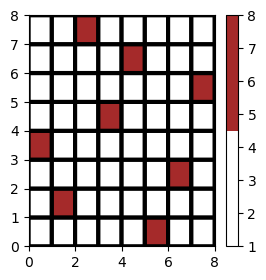

{'success': True,
 'sol': array([2, 4, 7, 3, 0, 6, 1, 5]),
 'niter': 9,
 'NEval': 360}

In [3]:
ga = EvolutionaryAlgorithmQueens(40, verbose=True)
ga.solve()